In [1]:
from qm.qua import *
from qm import QuantumMachinesManager
from qm import SimulationConfig
from configuration import *
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.plot import interrupt_on_close
from qualang_tools.loops import from_array
import matplotlib.pyplot as plt
from qualang_tools.results.data_handler import DataHandler
import sys
sys.path.append(r'C:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\OPX_setup_06022025')
sys.path.append(r'C:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\OPX_setup_06022025\opx_github_scripts')
import classifiers.classifier as classifier
from scipy.optimize import minimize
import pandas as pd
import joblib
import os
import pickle
from scipy.optimize import curve_fit

2025-07-04 10:41:36,083 - qm - INFO     - Starting session: f2736499-8a84-4b41-aa65-8373b3c687d5
30675000
resonator_IF_q1: 102535000, resonator_IF_q2: 30675000


In [3]:

##############
# Parameters #
##############

n_avg = 18000

# time of rabi pulses 
t_min = 16// 4
t_max = 15000 // 4

dt = 120//4


durations = np.arange(t_min, t_max, dt)
# amplitude=.005#.5
# a_to_J = ((2 * np.pi) / (2 * (2 * 40 * 10**-3))) 
# print(f"drive_J={amplitude*a_to_J} rad/micros")
# rabi_drive_phase = -0.005

amp_list=np.linspace(0,.05,101)
scale_matrix= joblib.load("scale_matrix.pkl")

In [4]:
def build_rabi_y_tomography_program(amplitude, durations):
    with program() as prog:
        # Declare variables
        n = declare(int)
        t = declare(int)
        I1 = declare(fixed)
        Q1 = declare(fixed)
        I2 = declare(fixed)
        Q2 = declare(fixed)
        I1_st, Q1_st = declare_stream(), declare_stream()
        I2_st, Q2_st = declare_stream(), declare_stream()

        # # Set frequency dynamically (you missed this line)
        # update_frequency("q1_xy_ef", frequency)

        with for_(n, 0, n < n_avg, n + 1):
            # reset_if_phase("q1_xy_ef")
            # reset_frame("q1_xy_ef")

            with for_(*from_array(t, durations)):
                # --- State prep: go to |e⟩ then superposition in ef
                align()
                play("x180", "q1_xy")
                align()
                play("x180_ef", "q1_xy_ef")
                align()
                # with strict_timing_():
                #     play("x180", "q1_xy")         # |g⟩ → |e⟩
                #     play("x90_ef", "q1_xy_ef")    # |e⟩ → (|e⟩ + |f⟩)/√2
                
                # --- ef Rabi drive with flattop
                play("fg_rise" * amp(amplitude), "q1_xy_ef")
                play("cw" * amp(amplitude), "q1_xy_ef", duration=t)
                play("fg_fall" * amp(amplitude), "q1_xy_ef")
                align()

                # --- Y-axis tomography pulse
                # frame_rotation_2pi(-0.001, "q1_xy_ef")
                # play("y90_ef", "q1_xy_ef")  # correct pulse name
                
                # align()

                # --- Swap and measure
                play("const", "coupler_1")
                align()
                measure("readout", "rr1", None,
                        dual_demod.full("rotated_cos_q1", "rotated_sin_q1", I1),
                        dual_demod.full("rotated_minus_sin_q1", "rotated_cos_q1", Q1))
                measure("readout", "rr2", None,
                        dual_demod.full("rotated_cos_q2", "rotated_sin_q2", I2),
                        dual_demod.full("rotated_minus_sin_q2", "rotated_cos_q2", Q2))
                wait(thermalization_time * u.ns, "rr1")
                wait(thermalization_time * u.ns, "rr2")

                # --- Save results
                save(I1, I1_st)
                save(Q1, Q1_st)
                save(I2, I2_st)
                save(Q2, Q2_st)
                align()

        # --- Stream results back
        with stream_processing():
            I1_st.save_all("I1_y")
            Q1_st.save_all("Q1_y")
            I2_st.save_all("I2_y")
            Q2_st.save_all("Q2_y")

    return prog

def run_tomo(amplitude):
    prog = build_rabi_y_tomography_program(amplitude, durations)
    qm = qmm.open_qm(config)
    job = qm.execute(prog)
    res = job.result_handles
    res.wait_for_all_values()
    return {
        "I1": res.get("I1_y").fetch_all()["value"],
        "Q1": res.get("Q1_y").fetch_all()["value"],
        "I2": res.get("I2_y").fetch_all()["value"],
        "Q2": res.get("Q2_y").fetch_all()["value"],
    }
def classify(res_dict):
    df = pd.DataFrame(res_dict)
    classified = classifier.classify(df)
    states = classified["predicted"]
    reshaped = classifier.reshape_for_exp(states, n_avg, len(durations))
    probs = classifier.probabilities(reshaped)

    P_matrix = np.array([probs["P_g"], probs["P_e"], probs["P_f"]])
    return P_matrix

def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [ ]:

time_vals_ns = 4 * durations            # durations in clk cycles → ns
all_P_f = []
all_P_e=[]
all_P_g=[]
qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
for a in amp_list:

    print(f"--------------------------\n Running for amp = {a} ... \n --------------------------")
    res = run_tomo(a)
    P_mat = classify(res)
    P_true=correct_probabilities_over_time(scale_matrix,P_mat)
    # P_f = P_true[2]/(P_true[1]+P_true[2])
    all_P_f.append(P_true[2])
    all_P_e.append(P_true[1])
    all_P_g.append(P_true[0])

2025-07-04 10:42:11,566 - qm - INFO     - Performing health check
2025-07-04 10:42:11,576 - qm - INFO     - Health check passed
--------------------------
 Running for amp = 0.0 ... 
 --------------------------


C:\Users\quantum1\AppData\Local\Temp\ipykernel_11112\2159591173.py:46: DeprecationWarning:

Putting `None` to indicate no adc streaming is no longer required, please remove it from the measure call.

C:\Users\quantum1\AppData\Local\Temp\ipykernel_11112\2159591173.py:49: DeprecationWarning:

Putting `None` to indicate no adc streaming is no longer required, please remove it from the measure call.



2025-07-04 10:42:11,944 - qm - INFO     - Sending program to QOP for compilation
2025-07-04 10:42:12,064 - qm - INFO     - Executing program


In [ ]:

flattop_gauss_amp=0.1
# Stack results into a 2D array: shape (len(J_vals), len(time_vals_ns))
P_f_matrix = np.array(all_P_f)
P_e_matrix = np.array(all_P_e)
plt.figure(figsize=(8, 6))
plt.imshow(P_f_matrix, aspect='auto', origin='lower',
           extent=[time_vals_ns[0], time_vals_ns[-1], amp_list[0]*flattop_gauss_amp, amp_list[-1]*flattop_gauss_amp],
           cmap='viridis')
plt.colorbar(label='P_f')
plt.xlabel("Time [ns]")
plt.title("Non-Hermitian Rabi: P_f vs Time and J")
plt.show()
save_dir = "sweep_J_data"
os.makedirs(save_dir, exist_ok=True)
filename = "pf_pe_pg_initf.pkl"
filepath = os.path.join(save_dir, filename)

with open(filepath, "wb") as f:
    pickle.dump({
        "all_P_f": all_P_f,
        "all_P_e": all_P_e,
        "all_P_g": all_P_g,
        "amplitude": amp_list*flattop_gauss_amp,
        "time_vals_ns": time_vals_ns
    }, f)

print(f"Saved: {filepath}")

In [46]:
from analysis import fit_sine_square_decay
from scipy.signal import savgol_filter
a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
def sweep_J_curve_fit(all_P_f, amplitude, time_vals_ns):
    """
    Loops over each amplitude, performs a renormalization and curve fit on the P_f data,
    and returns a dictionary mapping J values to the extracted Rabi angular frequency.
    """
    omega_values = {}

    for idx, amp in enumerate(amplitude):
        P_f = all_P_f[idx]
        times = time_vals_ns * 1e-3  # convert to us

        J = amp * a_to_J

        guess_gamma = np.sqrt(abs(0.14**2 - J**2))
        guess_freq = np.sqrt(abs(0.14**2 - J**2)) / np.pi

        if J <= .4:
            time_mask = times <15 #< 10
            window_length = 40
            poly_order = 2    # polynomial order
            P_f  = savgol_filter(P_f , window_length, poly_order)
            lower_bounds = [0, 0, 0, 0, -np.inf]
            upper_bounds = [.3, 0.6, np.inf, np.inf, np.inf]
            guess_vals = [0.018916989255931358, .48, 10, 0.5,0]
            P_f=P_f[time_mask]
            fit_times=times[time_mask]
        else:
            lower_bounds = [0, 0, 0, -np.inf, -np.inf]
            upper_bounds = [.3, 1, np.inf, np.inf, np.inf]
            #guess_vals = [0, 0.5, (J/np.sqrt(abs(0.2**2 - J**2)))**2, 0, 0.02]
            fit_times = times

        fit_vals_f, _, _, _ = fit_sine_square_decay(
            fit_times, P_f, guess_vals=None, lower_bounds=lower_bounds, upper_bounds=upper_bounds
        )
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)
        print(f"J = {J}: Angular freq (rad/μs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values


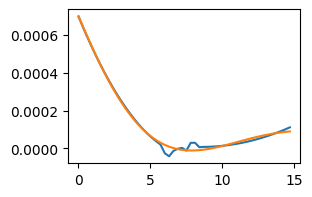

freq:0.02332214189514663,gamma: 0.12168014884514981, amp:0.0008509797429748227, phase_deg: 113.85921846672818,offset: -1.067021124888398e-05,
J = 0.0: Angular freq (rad/μs): 0.14653733928754278
RuntimeError


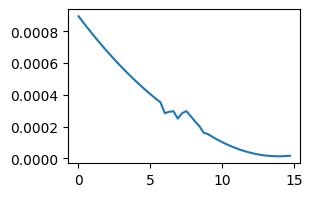

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.016774950787754903: Angular freq (rad/μs): nan


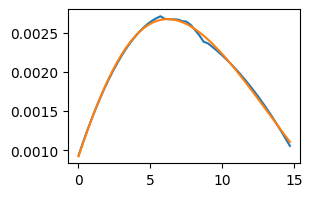

freq:0.01075431365454343,gamma: 0.15585852435492026, amp:0.02235377096309596, phase_deg: 16.901230217017826,offset: -0.000974044423015485,
J = 0.033549901575509807: Angular freq (rad/μs): 0.06757134554302807
RuntimeError


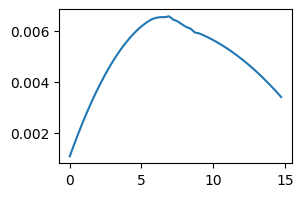

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.05032485236326471: Angular freq (rad/μs): nan
RuntimeError


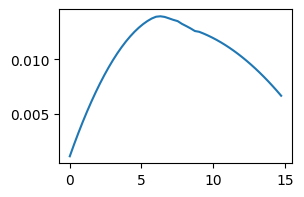

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.06709980315101961: Angular freq (rad/μs): nan
RuntimeError


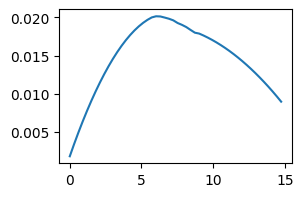

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.08387475393877451: Angular freq (rad/μs): nan
RuntimeError


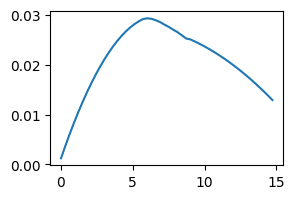

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.10064970472652943: Angular freq (rad/μs): nan
RuntimeError


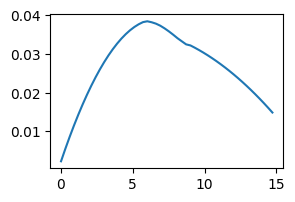

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.11742465551428434: Angular freq (rad/μs): nan


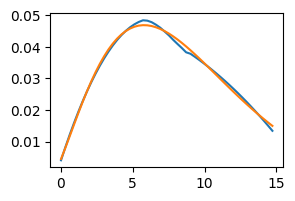

freq:0.007884559782862609,gamma: 0.26452835981877065, amp:1.978968825729967, phase_deg: 4.105152850710764,offset: -0.005819323724505373,
J = 0.13419960630203923: Angular freq (rad/μs): 0.049540150181261414


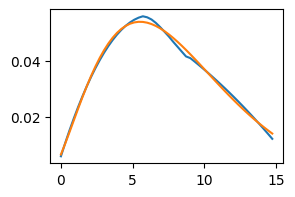

freq:0.012603370545221437,gamma: 0.2656584142244516, amp:0.9458674686240042, phase_deg: 5.771178137502162,offset: -0.003221455199608317,
J = 0.15097455708979415: Angular freq (rad/μs): 0.0791893126306753


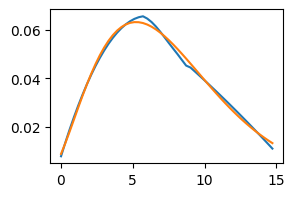

freq:0.016130289206047938,gamma: 0.2727196821793344, amp:0.7442399247808554, phase_deg: 6.232182012115132,offset: -0.0002210391986255317,
J = 0.16774950787754903: Angular freq (rad/μs): 0.10134959613999787


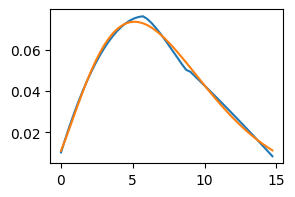

freq:0.01860828950937086,gamma: 0.25367264149832386, amp:0.6032208471878809, phase_deg: 8.365034407287625,offset: -0.0019488849032551128,
J = 0.18452445866530395: Angular freq (rad/μs): 0.11691933123702303
RuntimeError


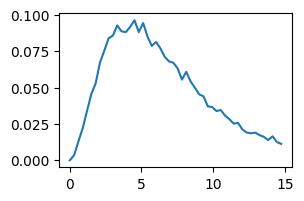

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.20129940945305885: Angular freq (rad/μs): nan
RuntimeError


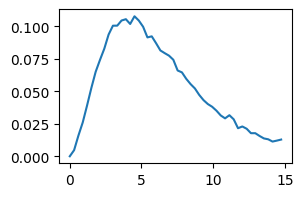

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.21807436024081378: Angular freq (rad/μs): nan
RuntimeError


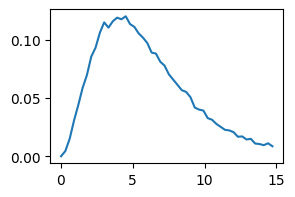

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.23484931102856868: Angular freq (rad/μs): nan


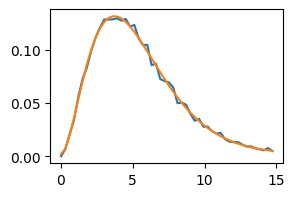

freq:0.01787086674017336,gamma: 0.506619505533053, amp:5.213421002306167, phase_deg: -0.057296186948222375,offset: 0.002107593038151714,
J = 0.2516242618163236: Angular freq (rad/μs): 0.1122859673284216


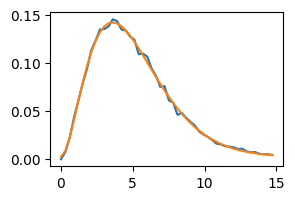

freq:0.021537908270287492,gamma: 0.5115769872077857, amp:4.020600961793623, phase_deg: -0.010752823553747437,offset: 0.002532822064778829,
J = 0.26839921260407845: Angular freq (rad/μs): 0.13532666879125207


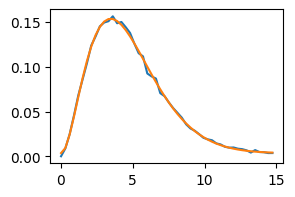

freq:0.026901008382158677,gamma: 0.515208308394742, amp:2.9875071321799256, phase_deg: -0.34513085495321383,offset: 0.0035588901442383763,
J = 0.2851741633918334: Angular freq (rad/μs): 0.16902402061509428


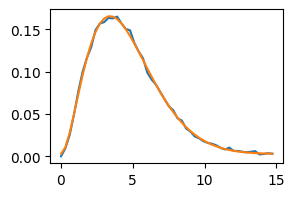

freq:0.03013633336235496,gamma: 0.4987481651084432, amp:2.457834753242043, phase_deg: 0.052192114509950094,offset: 0.0028846917426078055,
J = 0.3019491141795883: Angular freq (rad/μs): 0.18935216699461466


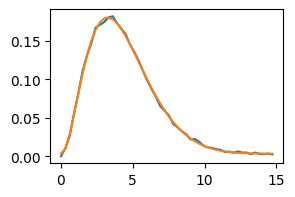

freq:0.033555050466193254,gamma: 0.5254281481903516, amp:2.505408608560803, phase_deg: -0.6348022936234352,offset: 0.003453756255529213,
J = 0.3187240649673432: Angular freq (rad/μs): 0.21083260007085497


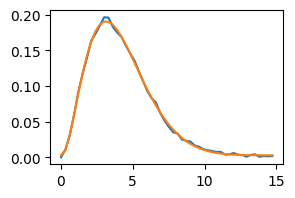

freq:0.0353204481910237,gamma: 0.5460020573932668, amp:2.6221489783575023, phase_deg: -0.817673058968812,offset: 0.0027975660077809794,
J = 0.33549901575509805: Angular freq (rad/μs): 0.22192492111683793


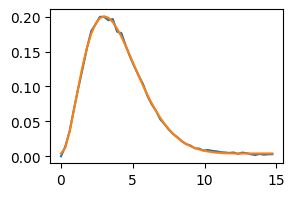

freq:0.03936787407575228,gamma: 0.5463257435310613, amp:2.274680208792447, phase_deg: -0.6791131918572023,offset: 0.003933384610409127,
J = 0.35227396654285303: Angular freq (rad/μs): 0.24735564796766285


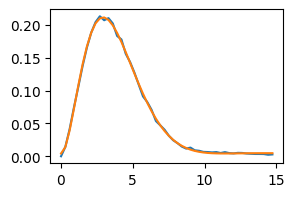

freq:0.043993555651395545,gamma: 0.5338804595448586, amp:1.9276766222752313, phase_deg: -0.558805949851507,offset: 0.004259703982878689,
J = 0.3690489173306079: Angular freq (rad/μs): 0.27641966247943595


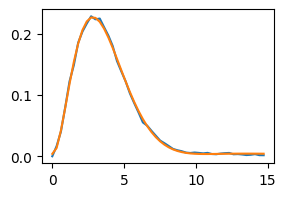

freq:0.046992695864176946,gamma: 0.5495274461332177, amp:1.985621372366108, phase_deg: -0.9457036667238081,offset: 0.0036843326136669096,
J = 0.3858238681183628: Angular freq (rad/μs): 0.2952638161985555


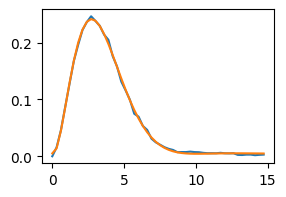

freq:0.050025570025416244,gamma: 0.5633511337610182, amp:2.0092347510788744, phase_deg: -1.3593810425184645,offset: 0.004396700292242056,
J = 0.4025988189061177: Angular freq (rad/μs): 0.3143199265669789


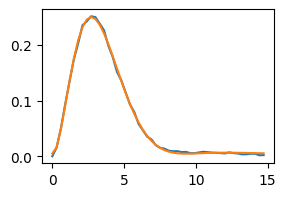

freq:0.05385606817943996,gamma: 0.5309582456692744, amp:1.687327591363605, phase_deg: -0.9708967631435447,offset: 0.004691322136037103,
J = 0.4193737696938727: Angular freq (rad/μs): 0.3383876562875192


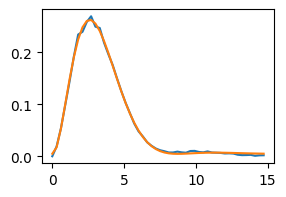

freq:0.05755005375917707,gamma: 0.539312682101288, amp:1.6536707347836523, phase_deg: -1.089718716573737,offset: 0.004627820388404947,
J = 0.43614872048162756: Angular freq (rad/μs): 0.3615976522070567


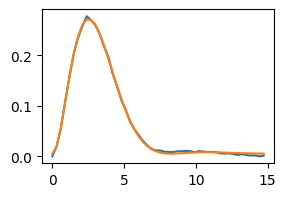

freq:0.06081068263736344,gamma: 0.5481331758577268, amp:1.6259016974464577, phase_deg: -1.2031813568983476,offset: 0.005108976844262766,
J = 0.45292367126938243: Angular freq (rad/μs): 0.3820847876666427


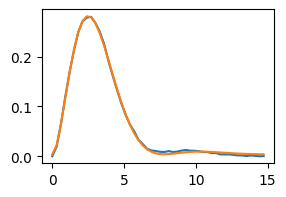

freq:0.06429564130970045,gamma: 0.5062605280054817, amp:1.3767025511720317, phase_deg: -0.17022200956960284,offset: 0.003959820457139844,
J = 0.46969862205713736: Angular freq (rad/μs): 0.4039814287927987


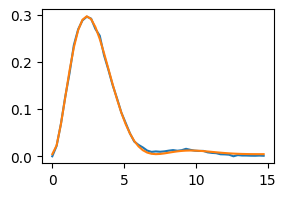

freq:0.06932927736298873,gamma: 0.5041752788549039, amp:1.3229256782210415, phase_deg: -0.5457451451209906,offset: 0.0045078271853318036,
J = 0.48647357284489223: Angular freq (rad/μs): 0.4356086968845091


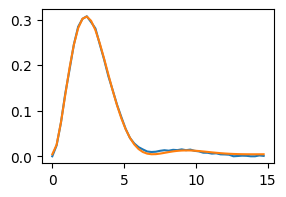

freq:0.07150651732312847,gamma: 0.5108032927019441, amp:1.3357426402701897, phase_deg: -0.3694216785037874,offset: 0.004385255318771892,
J = 0.5032485236326472: Angular freq (rad/μs): 0.44928869901226337


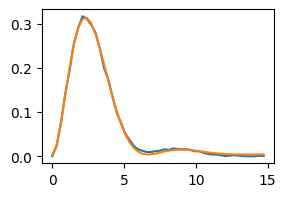

freq:0.07520047296042968,gamma: 0.499663902611299, amp:1.2667584812644386, phase_deg: -0.6292826863747721,offset: 0.003997570092873002,
J = 0.5200234744204021: Angular freq (rad/μs): 0.47249850679792754


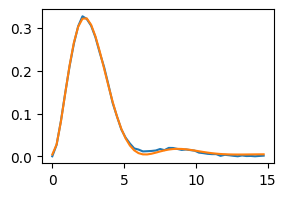

freq:0.07727432011333099,gamma: 0.491579293825545, amp:1.2333279001490283, phase_deg: -0.20841242541261207,offset: 0.004118418304551811,
J = 0.5367984252081569: Angular freq (rad/μs): 0.48552887275837325


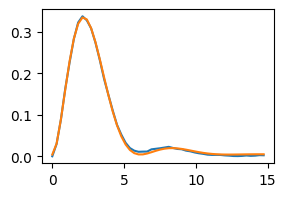

freq:0.0813754495576082,gamma: 0.4975166328914403, amp:1.2194181677918385, phase_deg: -0.10955672651654604,offset: 0.004148002130532006,
J = 0.5535733759959119: Angular freq (rad/μs): 0.5112970290254973


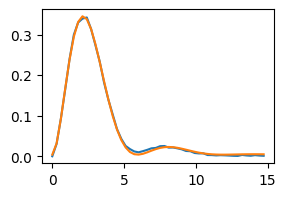

freq:0.08409952986624569,gamma: 0.4861163225080514, amp:1.181096434184554, phase_deg: -0.06382191242729948,offset: 0.004012662356997254,
J = 0.5703483267836668: Angular freq (rad/μs): 0.5284129303963058


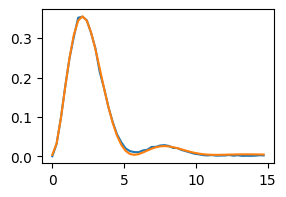

freq:0.08767447331936094,gamma: 0.4844918910360098, amp:1.165674635417122, phase_deg: -0.22228895847185168,offset: 0.00360598213951297,
J = 0.5871232775714217: Angular freq (rad/μs): 0.5508749625749173


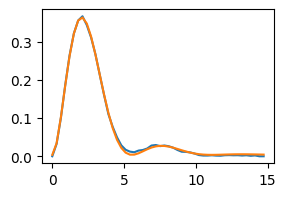

freq:0.09013244371582962,gamma: 0.4907084435822937, amp:1.1762049102961007, phase_deg: -0.24943075160764422,offset: 0.0037278935934026963,
J = 0.6038982283591766: Angular freq (rad/μs): 0.5663188460554918


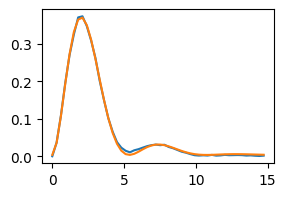

freq:0.09318477232344527,gamma: 0.48058545406356074, amp:1.136036600052564, phase_deg: -0.1311136891803091,offset: 0.0036044889388980035,
J = 0.6206731791469314: Angular freq (rad/μs): 0.5854971923155463


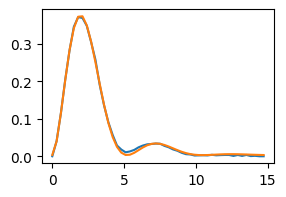

freq:0.09544857745013803,gamma: 0.4737229391390697, amp:1.1036656532330864, phase_deg: 0.5071435535446625,offset: 0.00306004700478951,
J = 0.6374481299346864: Angular freq (rad/μs): 0.5997210994259


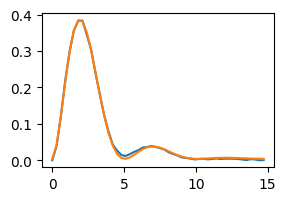

freq:0.09856690188758829,gamma: 0.47629668827376787, amp:1.102235492210827, phase_deg: 0.40363378952497037,offset: 0.00391554443483034,
J = 0.6542230807224413: Angular freq (rad/μs): 0.6193141097143066


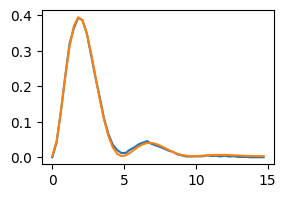

freq:0.10196579874798721,gamma: 0.4786551575857727, amp:1.096119422326498, phase_deg: 0.5416651415611411,offset: 0.003160385392294366,
J = 0.6709980315101961: Angular freq (rad/μs): 0.6406700085281839


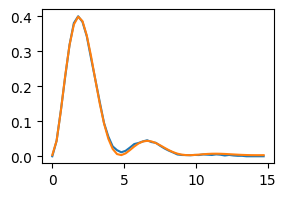

freq:0.1049665364045675,gamma: 0.476242810594229, amp:1.0824086790694913, phase_deg: 0.19537357911925388,offset: 0.00315768376161288,
J = 0.6877729822979511: Angular freq (rad/μs): 0.6595241992827097


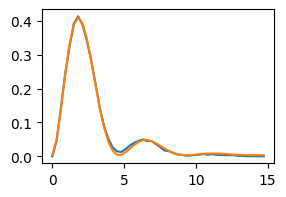

freq:0.10679055873612443,gamma: 0.469408710052775, amp:1.0746644071199476, phase_deg: 0.561832937627082,offset: 0.003210138705707299,
J = 0.7045479330857061: Angular freq (rad/μs): 0.6709848695963156


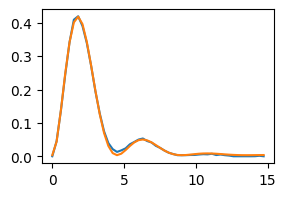

freq:0.11112041436216358,gamma: 0.4842162129991905, amp:1.1070513765564527, phase_deg: -0.6987736664899021,offset: 0.003275619988472983,
J = 0.721322883873461: Angular freq (rad/μs): 0.6981901548480537


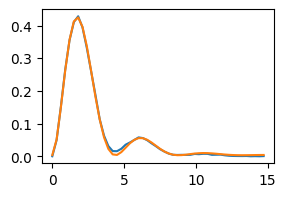

freq:0.11346011220393912,gamma: 0.4715285984379025, amp:1.069030710426163, phase_deg: 0.30080799166363514,offset: 0.0032492910730530784,
J = 0.7380978346612158: Angular freq (rad/μs): 0.7128909099507376


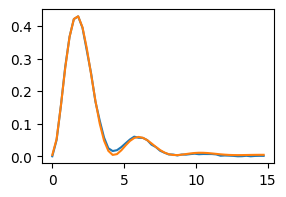

freq:0.11615392449997317,gamma: 0.4735209608550927, amp:1.0711956599948183, phase_deg: 0.12591838562113186,offset: 0.0035890563465219446,
J = 0.7548727854489706: Angular freq (rad/μs): 0.7298166317894783


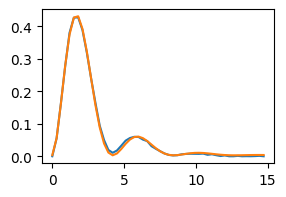

freq:0.11805633564411296,gamma: 0.47500254555408256, amp:1.0640531466252792, phase_deg: 0.4539002785100931,offset: 0.0029855229437966376,
J = 0.7716477362367256: Angular freq (rad/μs): 0.7417698335385522


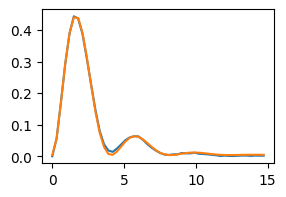

freq:0.12169299668609908,gamma: 0.4860557956864672, amp:1.0854491057247646, phase_deg: -0.018422325082531294,offset: 0.0037784735232749855,
J = 0.7884226870244805: Angular freq (rad/μs): 0.7646196487647519


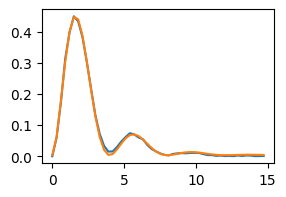

freq:0.1242888678449584,gamma: 0.4713277017969961, amp:1.047450979149729, phase_deg: 0.5919160845588652,offset: 0.00345705883088613,
J = 0.8051976378122354: Angular freq (rad/μs): 0.780929988289428


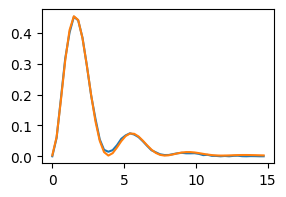

freq:0.12708878059430295,gamma: 0.4674093336340594, amp:1.0407601968104856, phase_deg: 0.5444384502180108,offset: 0.0022959211367127087,
J = 0.8219725885999903: Angular freq (rad/μs): 0.7985223589374945


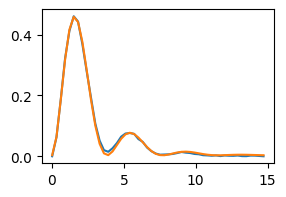

freq:0.12987530528547211,gamma: 0.47201168276305855, amp:1.0397621009527458, phase_deg: 0.2736261034066179,offset: 0.003191557943098168,
J = 0.8387475393877454: Angular freq (rad/μs): 0.8160306099351416


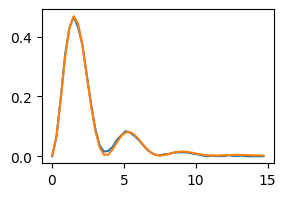

freq:0.13301028165296885,gamma: 0.47062248098505577, amp:1.0400163385617207, phase_deg: 0.3596076845045754,offset: 0.0023874404988507947,
J = 0.8555224901755002: Angular freq (rad/μs): 0.8357282473857524


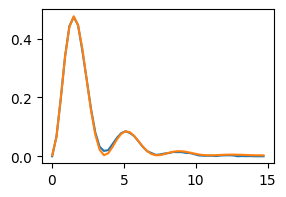

freq:0.13658686829649472,gamma: 0.4785593374691355, amp:1.0549235934539536, phase_deg: -0.4097729018433734,offset: 0.0032011349059640655,
J = 0.8722974409632551: Angular freq (rad/μs): 0.8582006040342088


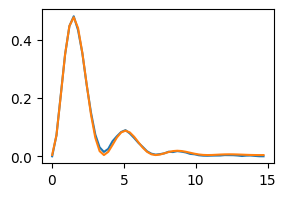

freq:0.13832418232870552,gamma: 0.479097478105313, amp:1.0441434824197535, phase_deg: 0.2686943734866269,offset: 0.004166512597824978,
J = 0.8890723917510099: Angular freq (rad/μs): 0.8691164700353528


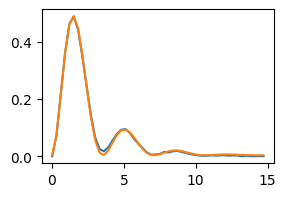

freq:0.1407698268099684,gamma: 0.4725028022536415, amp:1.0460162264229227, phase_deg: 0.15943058326118412,offset: 0.003485421682184369,
J = 0.9058473425387649: Angular freq (rad/μs): 0.8844829075066085


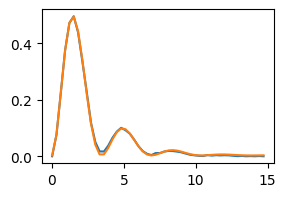

freq:0.14442498804385226,gamma: 0.47181576299181993, amp:1.044017430794908, phase_deg: 0.16296929594645634,offset: 0.0029111282783770443,
J = 0.9226222933265198: Angular freq (rad/μs): 0.9074489628667199


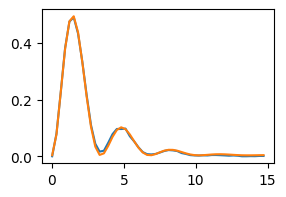

freq:0.14681115744974516,gamma: 0.4721339601484252, amp:1.0367855810812854, phase_deg: 0.05055944287254146,offset: 0.003350207952173402,
J = 0.9393972441142747: Angular freq (rad/μs): 0.9224417074182676


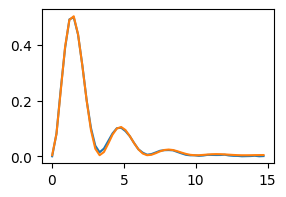

freq:0.14936727815783618,gamma: 0.4781778589773313, amp:1.0572367965441491, phase_deg: -0.0585528790847304,offset: 0.003662958658379542,
J = 0.9561721949020295: Angular freq (rad/μs): 0.9385022874947226


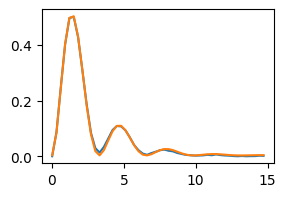

freq:0.15225658878915008,gamma: 0.46952131226431154, amp:1.0333495315904258, phase_deg: 0.31416441650200294,offset: 0.003000482228777413,
J = 0.9729471456897845: Angular freq (rad/μs): 0.9566563616012719


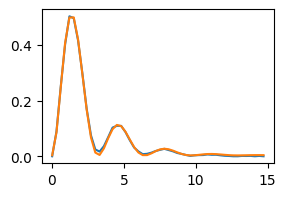

freq:0.1547924372516401,gamma: 0.47233166362451423, amp:1.0265294769851352, phase_deg: 0.2294243214686688,offset: 0.003132161384384064,
J = 0.9897220964775394: Angular freq (rad/μs): 0.9725895674020232


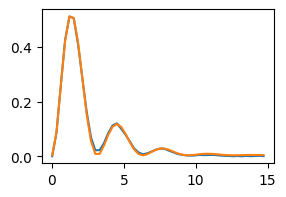

freq:0.15833839854971343,gamma: 0.47752295234164993, amp:1.0435792802212498, phase_deg: -0.17392557243437612,offset: 0.0036101296326405217,
J = 1.0064970472652943: Angular freq (rad/μs): 0.994869499329905


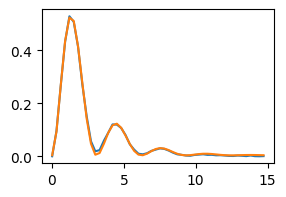

freq:0.1604171518987828,gamma: 0.47423518768168765, amp:1.0427862241034647, phase_deg: 0.16467556364126032,offset: 0.003473650093761667,
J = 1.0232719980530491: Angular freq (rad/μs): 1.007930691830028


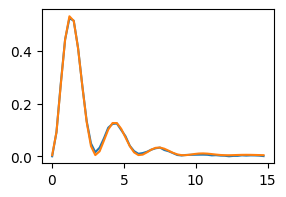

freq:0.16391896816312057,gamma: 0.4745897772714715, amp:1.0470414874626663, phase_deg: -0.501626324907608,offset: 0.003941238318539569,
J = 1.0400469488408042: Angular freq (rad/μs): 1.0299332523305575


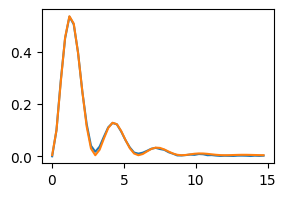

freq:0.16603697096844444,gamma: 0.4820133139380131, amp:1.049757638151673, phase_deg: 0.14225314166835965,offset: 0.004041575815705046,
J = 1.056821899628559: Angular freq (rad/μs): 1.0432410564375336


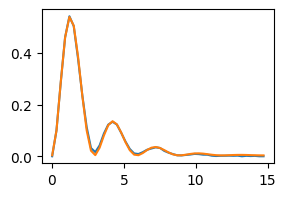

freq:0.16918015235800773,gamma: 0.4747200335517743, amp:1.0360971311040186, phase_deg: -0.060843304872976275,offset: 0.0034470503189938835,
J = 1.0735968504163138: Angular freq (rad/μs): 1.062990247562238


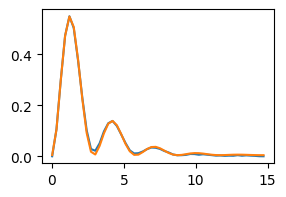

freq:0.17118955582510273,gamma: 0.4789321519265412, amp:1.0446339068428807, phase_deg: 0.08115171039298893,offset: 0.004355755131423949,
J = 1.0903718012040688: Angular freq (rad/μs): 1.075615701902885


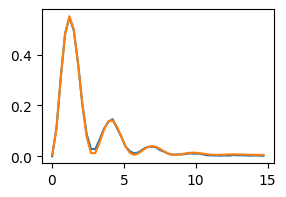

freq:0.174743375262003,gamma: 0.4802212283871992, amp:1.032002070818776, phase_deg: 0.15532237054571754,offset: 0.005487348190040196,
J = 1.1071467519918239: Angular freq (rad/μs): 1.097945007973186


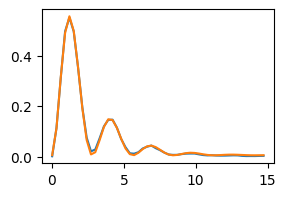

freq:0.17739060168071477,gamma: 0.47236662681331937, amp:1.0259871162284522, phase_deg: 0.2296113135822557,offset: 0.005144800630467217,
J = 1.1239217027795787: Angular freq (rad/μs): 1.1145780221120134


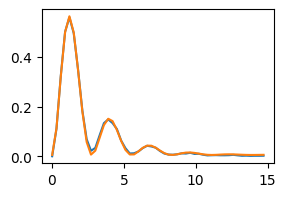

freq:0.18019201896460302,gamma: 0.4821286660677197, amp:1.0413586045853085, phase_deg: -0.28859119377453246,offset: 0.006168921147446056,
J = 1.1406966535673335: Angular freq (rad/μs): 1.132179846029419


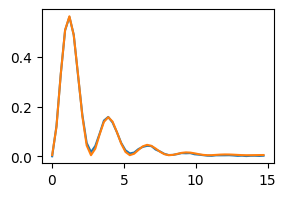

freq:0.18318079824506217,gamma: 0.47525627401302517, amp:1.0283839786317883, phase_deg: 0.24956205653772046,offset: 0.004286388741450835,
J = 1.1574716043550886: Angular freq (rad/μs): 1.1509589000908027


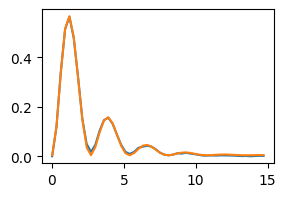

freq:0.18569295379890946,gamma: 0.48144915054112736, amp:1.0338051299516793, phase_deg: 0.03682941090771511,offset: 0.004051725413293725,
J = 1.1742465551428434: Angular freq (rad/μs): 1.1667432389560857


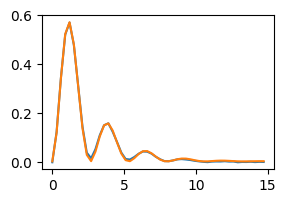

freq:0.18793995211846537,gamma: 0.4845271576448382, amp:1.0438430332933148, phase_deg: -0.1774598092979544,offset: 0.0035174536345589725,
J = 1.1910215059305984: Angular freq (rad/μs): 1.1808615457827765


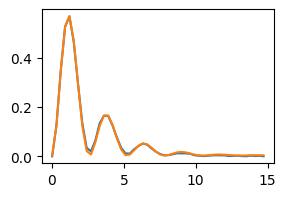

freq:0.1910012462822282,gamma: 0.4661991063041057, amp:1.0124646625443776, phase_deg: 0.19356508259715935,offset: 0.00304215728724791,
J = 1.2077964567183532: Angular freq (rad/μs): 1.2000962242934858


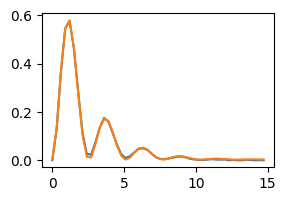

freq:0.19432187473802623,gamma: 0.47793409094866635, amp:1.0388666675928868, phase_deg: 0.023870464461015043,offset: 0.0026895475671559303,
J = 1.224571407506108: Angular freq (rad/μs): 1.2209603482175584


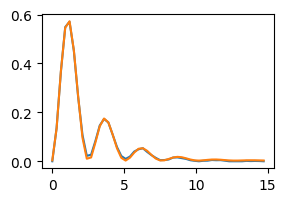

freq:0.1962366160599688,gamma: 0.47522209636386326, amp:1.0196322067575359, phase_deg: 0.47028587125492627,offset: 0.0028063995838568043,
J = 1.2413463582938629: Angular freq (rad/μs): 1.2329910227586376


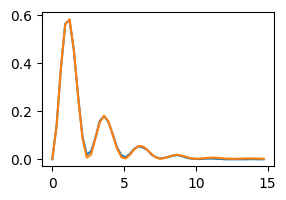

freq:0.19855577986271997,gamma: 0.4754265836457363, amp:1.0357607541500338, phase_deg: 0.3667841449858569,offset: 0.0019750305052605266,
J = 1.2581213090816177: Angular freq (rad/μs): 1.2475627586890266


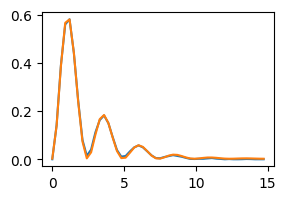

freq:0.2022895887780234,gamma: 0.47754915880053034, amp:1.0345476492581738, phase_deg: 0.1016984586509375,offset: 0.002241610248042019,
J = 1.2748962598693727: Angular freq (rad/μs): 1.271022972005477


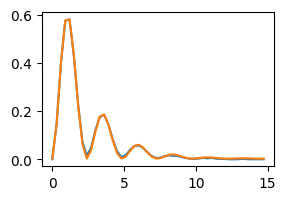

freq:0.20487933976499065,gamma: 0.47706191769510015, amp:1.0326765005415965, phase_deg: 0.3475850813721481,offset: 0.0024903826960753646,
J = 1.2916712106571275: Angular freq (rad/μs): 1.2872948573560437


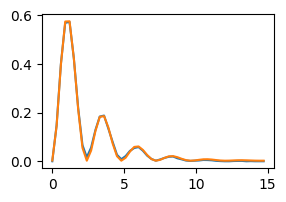

freq:0.2070303667532792,gamma: 0.4750500258696865, amp:1.0196603644315654, phase_deg: 0.2080228798652365,offset: 0.002398085335955535,
J = 1.3084461614448826: Angular freq (rad/μs): 1.3008101585242051


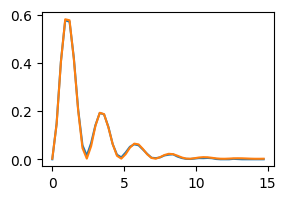

freq:0.2101210434841191,gamma: 0.4705632874121838, amp:1.0195462912086688, phase_deg: -0.10666213533357698,offset: 0.0020882561247573673,
J = 1.3252211122326376: Angular freq (rad/μs): 1.3202294531486602


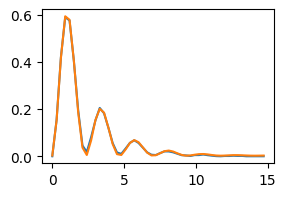

freq:0.21313702033429216,gamma: 0.4733685194621475, amp:1.0275447345282667, phase_deg: 0.08361933116964673,offset: 0.002507610185306947,
J = 1.3419960630203922: Angular freq (rad/μs): 1.339179394580461


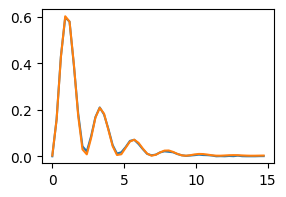

freq:0.21564202998322243,gamma: 0.4708777611564557, amp:1.029640321198686, phase_deg: 0.1832149655748524,offset: 0.0023609993995505458,
J = 1.3587710138081475: Angular freq (rad/μs): 1.354918834400963


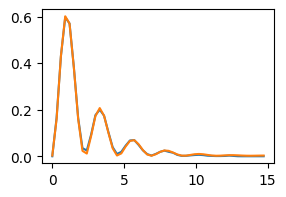

freq:0.21800073962343466,gamma: 0.47688716232350603, amp:1.0231925701447517, phase_deg: 0.2327667105062256,offset: 0.0022668806547753413,
J = 1.3755459645959023: Angular freq (rad/μs): 1.3697390441562474


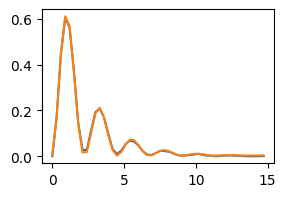

freq:0.22087579572370292,gamma: 0.4755564985483679, amp:1.0248495860997247, phase_deg: 0.5397041659935568,offset: 0.0028182013213507748,
J = 1.392320915383657: Angular freq (rad/μs): 1.3878035544027698


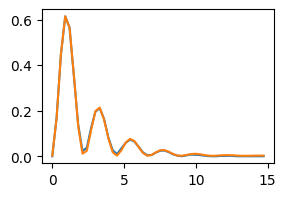

freq:0.2240552704425451,gamma: 0.4741718405183107, amp:1.0228940085166398, phase_deg: 0.17992454658808535,offset: 0.00195381509879005,
J = 1.4090958661714121: Angular freq (rad/μs): 1.407780783240748


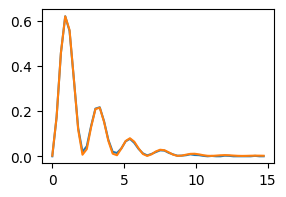

freq:0.22671500427200605,gamma: 0.47048508549255297, amp:1.0154469656715668, phase_deg: 0.49799000512522307,offset: 0.0016104992690919233,
J = 1.425870816959167: Angular freq (rad/μs): 1.4244923837590255


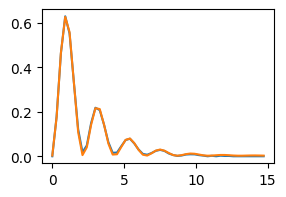

freq:0.2297185383952263,gamma: 0.47761459978657217, amp:1.0300767752478108, phase_deg: 0.11687979351357085,offset: 0.0025337430083260983,
J = 1.442645767746922: Angular freq (rad/μs): 1.4433641452316555


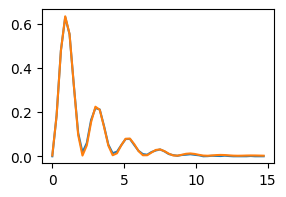

freq:0.2320207256238344,gamma: 0.4769581066503523, amp:1.0273489778124707, phase_deg: 0.5233382970168178,offset: 0.0024085000288627486,
J = 1.4594207185346768: Angular freq (rad/μs): 1.4578292142008225


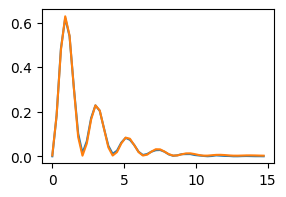

freq:0.23448818984780737,gamma: 0.47452328795618226, amp:1.0130774819182735, phase_deg: 0.4296291504208543,offset: 0.002647618386167661,
J = 1.4761956693224316: Angular freq (rad/μs): 1.4733327491588806


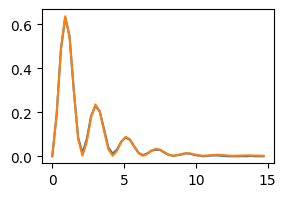

freq:0.23693899808733979,gamma: 0.47315057568260444, amp:1.0203993520779757, phase_deg: 0.2867533901301447,offset: 0.002408495939923471,
J = 1.4929706201101864: Angular freq (rad/μs): 1.4887316314802255


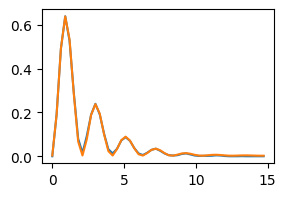

freq:0.24001957330970589,gamma: 0.4775211329867543, amp:1.0199429546072387, phase_deg: 0.2014113803694446,offset: 0.0025719905131643527,
J = 1.5097455708979413: Angular freq (rad/μs): 1.5080874564550575


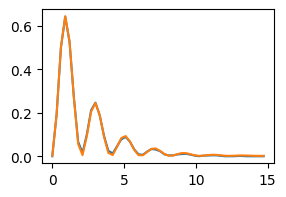

freq:0.24332256718909695,gamma: 0.4712601359245022, amp:1.0181226588344154, phase_deg: 0.05226461124049838,offset: 0.0019310937000361248,
J = 1.5265205216856963: Angular freq (rad/μs): 1.5288407790677516


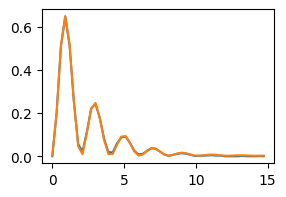

freq:0.24613825380686707,gamma: 0.47186007375703515, amp:1.013964524097516, phase_deg: 0.35407087325143294,offset: 0.002540578355152627,
J = 1.5432954724734511: Angular freq (rad/μs): 1.546532259854147


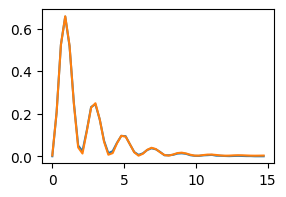

freq:0.24830868532095604,gamma: 0.4744034380618432, amp:1.0308345174737694, phase_deg: 0.3025581687577573,offset: 0.002760181697840156,
J = 1.5600704232612062: Angular freq (rad/μs): 1.5601694832537103


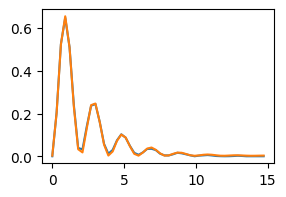

freq:0.2520830538269499,gamma: 0.4731797109608028, amp:1.0236594945902369, phase_deg: -0.21625439154080942,offset: 0.002355206740709965,
J = 1.576845374048961: Angular freq (rad/μs): 1.5838845399944523


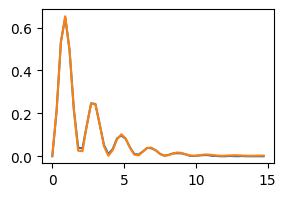

freq:0.25396983351886293,gamma: 0.4746729156634157, amp:1.0152541310885261, phase_deg: 0.3971014430165661,offset: 0.0023164153047987917,
J = 1.593620324836716: Angular freq (rad/μs): 1.5957395264325651


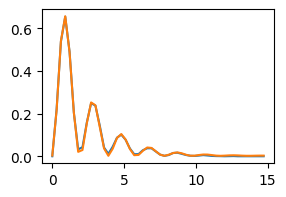

freq:0.2563208560344432,gamma: 0.4764323060018444, amp:1.0202625400529517, phase_deg: 0.43009317093952165,offset: 0.002184316471145062,
J = 1.6103952756244708: Angular freq (rad/μs): 1.6105114365593076


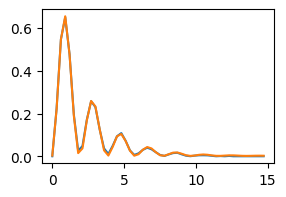

freq:0.25901983553131647,gamma: 0.4763510515346267, amp:1.015231739840466, phase_deg: 0.6048943876907846,offset: 0.0017890077024161814,
J = 1.6271702264122256: Angular freq (rad/μs): 1.6274696248784406


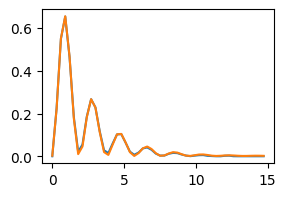

freq:0.2622112490154888,gamma: 0.4721625937848454, amp:1.009551702695651, phase_deg: 0.42937774318275973,offset: 0.0015216683623010352,
J = 1.6439451771999807: Angular freq (rad/μs): 1.647521867191327


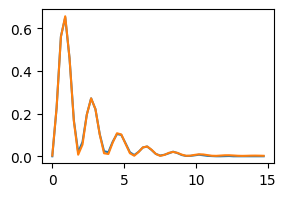

freq:0.2646513398384317,gamma: 0.4740024463692537, amp:1.0120462443056808, phase_deg: 0.5128486856696536,offset: 0.0019121986012590588,
J = 1.6607201279877355: Angular freq (rad/μs): 1.6628534099982255


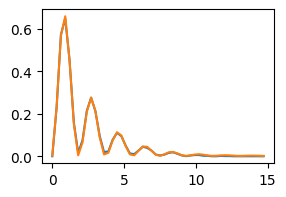

freq:0.26780700382022643,gamma: 0.4754267609697191, amp:1.0183015524876065, phase_deg: 0.32184292078154036,offset: 0.0018089134462340288,
J = 1.6774950787754908: Angular freq (rad/μs): 1.682681031563034


In [47]:
with open(filepath, "rb") as f:
    data = pickle.load(f)
all_P_f = data["all_P_f"]        # list of arrays, each for an amplitude
amplitude = data["amplitude"]    # list/array of amplitude values
time_vals_ns = data["time_vals_ns"]

omega_values = sweep_J_curve_fit(all_P_f, amplitude, time_vals_ns)

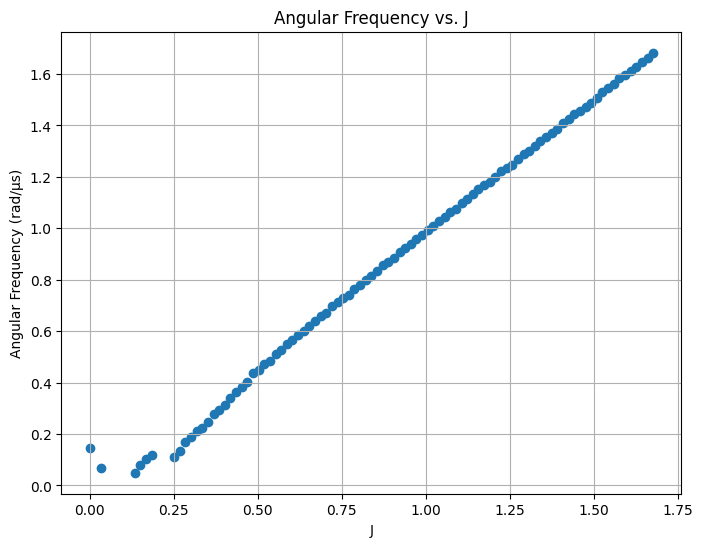

In [48]:
# for J, omega in omega_values.items():
#     print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_values.keys())
omegas = [omega_values[J] for J in J_vals]
plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

In [49]:
def fit_func(J, A, J0):
    expr = J**2 - J0**2
    return np.where(expr >= 0, A * np.sqrt(expr), 0.0)

def curve_fit_function(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(A * sqrt(J - J0^2))
    using the provided initial guesses for A and J0.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            Optimal values for the parameters [A, J0].
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_A, initial_guess_J0])
    return popt, pcov

def curve_fit_and_plot(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the given data to the model function f(J) = Re(A * sqrt(J - J0^2))
    and plots the original data (as a scatter plot) along with the fitted curve.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            The optimal parameters [A, J0] from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameters.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_A, initial_guess_J0)
    fitted_A, fitted_J0 = popt
    print("Fitted A =", fitted_A)
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_A, fitted_J0)
    
    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30, alpha = .5)
    plt.xlabel("J")
    plt.ylabel("alpha=Re(A * sqrt(J^2 - J0^2))")
    plt.title("alpha vs J")
    plt.legend()
    # plt.grid(True)
    plt.show()
    
    return popt, pcov

Fitted A = 1.012804656701071
Fitted J0 = 0.23554952274996824


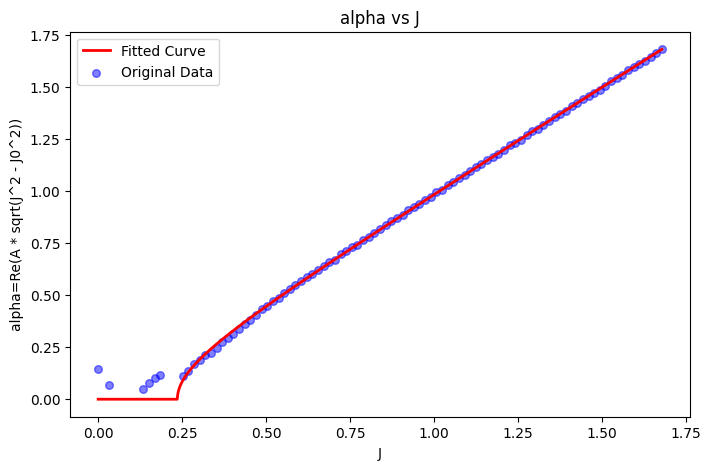

In [50]:
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
J_vals_array = np.array(J_vals)
omegas_array = np.array(omegas)
mask_rb = ~np.isnan(omegas)#(J_vals_array < 1) &
# Assuming J_vals and omegas are defined and mask_rb selects the non-NaN entries.

X
# Set your initial guess values
initial_guess_J0 = 0.2# for example
initial_guess_A0 = 1
# Now, call your curve fitting and plotting function with the first 100 data points.
popt, pcov = curve_fit_and_plot(J_vals_array[mask_rb], omegas_array[mask_rb], initial_guess_A0,initial_guess_J0)


In [37]:
J_0 = 0.24133459811273505

a_to_J = ((2 * np.pi) / (2 * (2 * 46.8197 * 1e-3))) / (1*flattop_gauss_amp)
J_to_a=1/a_to_J
a_0=J_0*J_to_a/flattop_gauss_amp
print(a_0)

0.007193302715644936


In [23]:
def decaying_sine(t, f, tau, A, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) * np.exp(-t / tau) + C

def decaying_sine_square(t, f, tau, A, phi, C):
    return A * (np.sin(2 * np.pi * f * t + phi)**2) * np.exp(-t / tau) + C

def try_fit_with_cutoff_square(t, Pf, cutoff_fraction=0.4):
    """Try fitting with early-time cutoff if full fit fails."""
    try:
        guess = [0.05, 0.0196398, -0.49676888, -0.62995933, 0.07540663]  # [f, tau, A, phi, C]
        popt, _ = curve_fit(decaying_sine_square, t, Pf, p0=guess, maxfev=10000)
        print(popt)
        return 2 * np.pi * popt[0], True
    except:
        # Try fitting only to early segment
        cutoff_idx = int(len(t) * cutoff_fraction)
        try:
            popt, _ = curve_fit(decaying_sine_square, t[:cutoff_idx], Pf[:cutoff_idx], p0=guess, maxfev=10000)
            return 2 * np.pi * popt[0], True
        except:
            return np.nan, False

def try_fit_with_cutoff(t, Pf, cutoff_fraction=0.4):
    """Try fitting with early-time cutoff if full fit fails."""
    try:
        guess = [0.05, 2, 0.5, 0, 0.5]  # [f, tau, A, phi, C]
        popt, _ = curve_fit(decaying_sine, t, Pf, p0=guess, maxfev=10000)
        return 2 * np.pi * popt[0], True
    except:
        # Try fitting only to early segment
        cutoff_idx = int(len(t) * cutoff_fraction)
        try:
            popt, _ = curve_fit(decaying_sine, t[:cutoff_idx], Pf[:cutoff_idx], p0=guess, maxfev=10000)
            return 2 * np.pi * popt[0], True
        except:
            return np.nan, False

def pt_model(J, gamma):
    """PT model: Omega(J) = sqrt(J^2 - gamma^2) if J > gamma else 0"""
    J, gamma = np.array(J), float(gamma)
    omega = np.sqrt(np.clip(J**2 - gamma**2, 0, None))
    return omega
time_vals_us = time_vals_ns * 1e-3
omega_vals = []
fit_success = []

[ 7.43388417e+00  1.30422237e-02 -7.52399627e-01 -7.72184297e-01
  1.36207074e-04]
[ 7.97214953e+00  1.36842484e-02 -7.65994871e-01 -7.64579222e-01
  3.23363400e-04]
[-0.2239046   0.00057977  0.19820464  0.15109409  0.00205806]
[-6.73312700e+00  4.16263962e-04  1.51645614e-01  2.93399542e-01
  4.97292910e-03]
[-1.00003117e+01  4.80405731e-04  2.56135861e-01  6.05038351e-01
  1.02540036e-02]
[-1.06053442e+01  5.04934443e-04  2.35637353e-01  7.33766129e-01
  1.47296340e-02]
[ 8.24939092  0.93755113 -0.05554704 -1.52788866  0.02348314]
[ 6.75392559  0.8948181  -0.06980469  0.02448145  0.03006883]
[-7.89864403e+00  6.27918231e-04  2.78659185e-02 -2.03627044e-01
  3.24321726e-02]
[-1.78154872  0.67841415 -0.1097401  -0.45567299  0.03989558]
[-8.39094444  0.01465985 -0.16366472 -0.21622572  0.04180939]
[ 8.20249028  0.54349446 -0.15599308 -1.42726486  0.05022203]
[-3.32880516e+00  1.79936100e-01 -7.48987448e+03  3.31901336e-01
  5.24961651e-02]
[-3.48519353  0.47017691 -0.18693257 -0.2378903

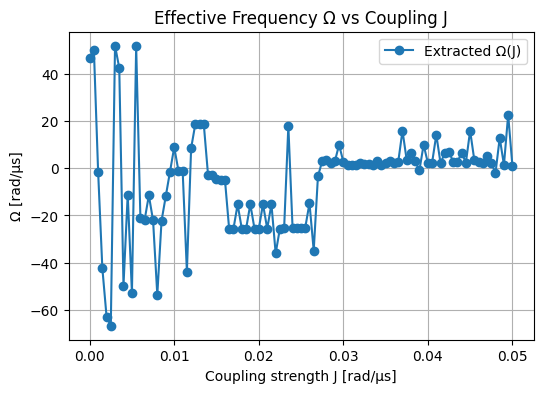

In [24]:
for P_f in all_P_f:
    omega, success = try_fit_with_cutoff_square(time_vals_us, P_f, cutoff_fraction=0.4)
    omega_vals.append(omega)
    fit_success.append(success)


fit_data = pd.DataFrame({
    "amps": amp_list,
    "Omega": omega_vals,
    "FitSuccess": fit_success
})
fit_data.to_csv("omega_vs_J_July2nd.csv", index=False)
plt.figure(figsize=(6, 4))
plt.plot(amp_list, omega_vals, "o-", label="Extracted Ω(J)")
plt.xlabel("Coupling strength J [rad/μs]")
plt.ylabel("Ω [rad/μs]")
plt.title("Effective Frequency Ω vs Coupling J")
plt.grid(True)
plt.legend()
plt.show()

In [25]:
save_dir = "sweep_J_data"
filename = "pf_pe_pg_july2nd.pkl"
filepath = os.path.join(save_dir, filename)
with open(filepath, "rb") as f:
    data = pickle.load(f)

all_P_f = np.array(data["all_P_f"])  # shape: (num_amps, num_time_steps)
all_P_e = np.array(data["all_P_e"])
all_P_g = np.array(data["all_P_g"])
amp_vals = np.array(data["amplitude"])
time_vals_ns = np.array(data["time_vals_ns"])


denom = all_P_f + all_P_e
norm_P_f = np.divide(all_P_f, denom, out=np.zeros_like(all_P_f), where=denom != 0)
norm_P_e = np.divide(all_P_e, denom, out=np.zeros_like(all_P_e), where=denom != 0)
# norm_P_f has shape (num_amps, num_time_steps)
time_vals_us = time_vals_ns * 1e-3  # Convert ns → µs


In [26]:
norm_omega_vals = []
fit_success_norm = []
time_vals_ns = 4 * durations            # durations in clk cycles → ns
time_vals_us = time_vals_ns * 1e-3  # Convert ns → µs

for Pf in norm_P_f:
    omega, success = try_fit_with_cutoff(time_vals_us, Pf, cutoff_fraction=0.8)
    norm_omega_vals.append(omega)
    fit_success_norm.append(success)
norm_fit_data = pd.DataFrame({
    "Amplitude": amp_vals,
    "Omega": norm_omega_vals,
    "FitSuccess": fit_success_norm
})
norm_fit_data.to_csv("omega_from_normalized_Pf_july2nd.csv", index=False)
print("Saved: omega_from_normalized_Pf_july2nd.csv")


Saved: omega_from_normalized_Pf_july2nd.csv


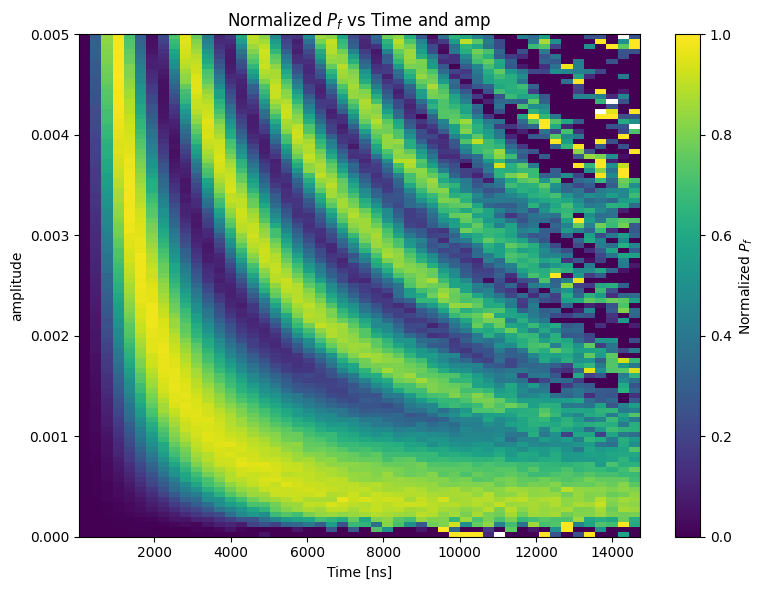

In [27]:
# Normalize P_f by (P_f + P_e)
norm_P_f_matrix = all_P_f / (all_P_f + all_P_e)

# Plot normalized P_f
plt.figure(figsize=(8, 6))
plt.imshow(norm_P_f_matrix, aspect='auto', origin='lower',
           extent=[time_vals_ns[0], time_vals_ns[-1], amp_list[0]*flattop_gauss_amp, amp_list[-1]*flattop_gauss_amp],
           cmap='viridis')
plt.colorbar(label='Normalized $P_f$')
plt.xlabel("Time [ns]")
plt.ylabel("amplitude")
plt.title("Normalized $P_f$ vs Time and amp")
plt.tight_layout()
plt.show()